## Step 1: Importing the Modules
To work the News API, we need to import the following modules:

* `NewsApiClient` from `newsapi`: This module will be used to interact with the API and get the news from different sources.
* `random`: This module will be used to generate random numbers for the news.
* `train_test_split` from `sklearn.model_selection`: This module will be used to create random training and testing subsets using the DataFrame.
* `CountVectorizer` from `sklearn.feature_extraction.text`: This module will be used to create a matrix of token count from the text document.
* `PassiveAggressiveClassifier` from `sklearn.linear_model`: This module will be used to create a linear model, `PassiveAggressiveClassifier` that will be used to classify the real news from fake news.
* `MultinomialNB` from `sklearn.naive_bayes`: This module will be used to initialize the `MultinomialNB` model that will be used to classify the real news from fake news.
* `RandomForestClassifier` from `sklearn.ensemble`: This module will be used to initialize the `RandomForestClassifier` model that will be used to classify the real news from fake news.
* `XGBClassifier` from `xgboost`: This module will be used to initialize the `XGBClassifier` wrapper of the xgb.train model used to classify the real news from fake news.
* `accuracy_score` and `confusion_matrix` from `sklearn.metrics`: These modules will be used to calculate the model’s accuracy by testing the model using the test data and to show the confusion matrix.

In [11]:
!pip3 install newsapi-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import seaborn as sns
import random
from newsapi import NewsApiClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Step 2: Method to Get News 
We will create a method to get the news data from the News API. To interact with the News API, an API key is required.

We will do the following:
* We call the `NewsApiClient()` method and pass the API key to this method.
* We then create a method to get the news data from the API. We use the `get_everything()` method from the `NewsApiClient` to get data and pass the following parameters to the method:

  * `sources`: This is used to specify the source to get news from. This is a comma-separated string.
  * `domains`: This is used to restrict the domain of search. This is a comma-separated string.
  * `from_param`: This specifies the oldest news to get from the API.
  * `to`: To specify the date of the newest news from the search.
  * `language`: This is used to specify the language of response from the API. 
  * `sort_by`: This is used to specify the order of the news to get from the search. Some possible options are `relevancy`, `popularity`, `publishedAt`. By default, the method will sort the records by their publishing date.
  * `page`: This is used to specify the page of the source to get the results from. By default this will use the first page to get the results.

* Finally after getting the results from the API, we will pass the results to an array and return that array.

In [13]:
prev_date = datetime.today() - timedelta(days=30)
next_date = datetime.today() - timedelta(days=0)

p_date = prev_date.strftime('%Y-%m-%d')
c_date = next_date.strftime('%Y-%m-%d')

newsapi = NewsApiClient(api_key='efc604f32dc1481b8a07c143946b3839')

def getNews(sourceId):
    newses = newsapi.get_everything(sources=sourceId,domains='bbc.co.uk,techcrunch.com',from_param=p_date,to=c_date,language='en',sort_by='relevancy',page=2)
    newsData = []
    for news in newses['articles']:
        list = [random.randint(0, 1000), news['title'],news['content'], 'REAL']
        newsData.append(list)
    return newsData

## Step 3: Get the News Sources

The official documentation of the News API says that there are `3000` authenticated news sources. We will now get the news sources using the News API. We will first get all the sources from the News API. Then we will add the ID of each source to a list. Finally we will truncate the list to a size of `10`, and get news from those sources.


In [14]:
sources = newsapi.get_sources()
sourceList = []
for source in sources['sources']:
    sourceList.append(source['id'])
del sourceList[10:len(sourceList)]
print('New Sources: ', sourceList)

New Sources:  ['abc-news', 'abc-news-au', 'aftenposten', 'al-jazeera-english', 'ansa', 'argaam', 'ars-technica', 'ary-news', 'associated-press', 'australian-financial-review']


## Step 4: Get News Using Multiple Sources
Now we will get news using multiple sources. After getting the news sources, we will use the `getNews()` method defined earlier to get the news from the API. Next we will create a new DataFrame using the news list and finally we will add new column headings to the DataFrame.

In [15]:
dataList = []
for sourceId in sourceList:
    newses = getNews(sourceId)
    dataList = dataList + newses

print('Total News: ', len(dataList))

Total News:  1000


In [16]:
df = pd.DataFrame.from_records(dataList)
df.columns = ['','title','text','label']
print(df.head())

                                                    title  \
0  335  Novak Djokovic has withdrawn from Madrid Open,...   
1  413  Timed Teaser: Which other A-lister watched Wre...   
2  892  Curious Alaskan moose visits the cinema for an...   
3  530   Nuclear weapons: Why South Koreans want the bomb   
4  681  Alejandro Toledo: Peru ex-president to be extr...   

                                                text label  
0  Novak Djokovic wore strapping on his right elb...  REAL  
1  Test your news knowledge against the clock. Ca...  REAL  
2  Alaskan moose visits the cinema...and steals p...  REAL  
3  Hidden away in the private room of an undergro...  REAL  
4  Former Peruvian President Alejandro Toledo has...  REAL  


## Step 5: Load and Concat the DataFrame

News API claims that all of their news are authenticated, therefore we will need another dataset that contains both fake news and real news to train the model. To create a DataFrame that consists of fake news and real news, we will load the data from the `news.csv` file. We will then add the column headings to the DataFrame. Finally we will use pandas to concat both DataFrames to create a new DataFrame.

In [17]:
trainData = pd.read_csv('news.csv')
trainData.columns = ['', 'title', 'text', 'label']
data = [trainData, df]
df = pd.concat(data)
print(df.head())

                                                      title  \
0   8476                       You Can Smell Hillary’s Fear   
1  10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608        Kerry to go to Paris in gesture of sympathy   
3  10142  Bernie supporters on Twitter erupt in anger ag...   
4    875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


## Step 6: Split the Training and Testing Data

We will now split the training and testing data from the DataFrame. We will use `70%` of the data for training and `30%` for testing. To split the training and testing data, use the `train_test_split()` method. We will set the following parameters:

  * `test_size`: This parameter accepts a floating value between `0.0` and `1.0` used to evaluate the percentage of testing data from the DataFrame, in our case we will set it to `0.3`.
  * `random_state`: This parameter accepts an integer value used to add a random shuffle to the DataFrame before applying the split, in our case we will set it to `7`.

In [18]:
training_x, testing_x, training_y, testing_y = train_test_split(df['text'], df.label, test_size=0.3, random_state=7)

## Step 7: Feature Selection
After splitting the training and testing data, let’s start the feature selection using the scikit-learn method `CountVectorizer()` which is used to convert text to numerical data. This method accepts the following parameters:

  * `stop_words`: Stop words such as “and,” “the,” and “him” are assumed to be uninformative in representing the content of a text. Therefore they can be removed to avoid being interpreted as a signal for prediction. Similar words can be helpful for prediction in some cases, such as classifying writing style or personality.
  * `max_df`: When creating the vocabulary, exclude terms with a document frequency that is strictly greater than the given threshold (corpus-specific stop words). If the parameter is a float, it represents a percentage of documents; otherwise, it means absolute counts. If the vocabulary is None, this parameter is ignored.

In [19]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.7)
feature_train = count_vectorizer.fit_transform(training_x)
feature_test = count_vectorizer.transform(testing_x)

## Step 8: Implement the Classifiers

Now that we are done with the feature selection part, let’s apply the classifier to the training data. To apply the classifier to the data, we will perform the following steps:

* First we will first initialize the `PassiveAggressiveClassifier`. Passive-aggressive algorithms are a family of algorithms for large-scale learning. They are similar to the Perceptron in that they do not require a learning rate. However, contrary to the Perceptron, they include a regularization parameter. This algorithm uses the passive technique, which states that if the prediction is correct, keep the model; only change the model if the prediction is incorrect.

  * We will then call the `fit()` method from the `PassiveAggressiveClassifier` and pass the features of the training data along with the labels.

* Next we will first initialize the `MultinomialNB`. A Naive Bayes classifier is a probabilistic machine learning model that’s used for the classification task. The Multinomial Naive Bayes classifier is suitable for classification with discrete features.

  * We will then also call the `fit()` method from the `MultinomialNB` and pass the features of the training data along with the labels.

  * We will again call the `fit()` method from the `XGBClassifier` and pass the features of the training data along with the labels.

* Next we initialize the `RandomForestClassifier`. RandomForest is a textbook technique often used for binary classification tasks of the kind. 

  * We will then also call the `fit()` method from the `RandomForestClassifier` and pass the features of the training data along with the labels.

### Initialize and Apply PassiveAggressiveClassifier

In [20]:
classifier = PassiveAggressiveClassifier(max_iter=50)
classifier.fit(feature_train, training_y)

PassiveAggressiveClassifier(max_iter=50)

### Initialize and Apply MultinomialNB

In [21]:
classifier2 = MultinomialNB()
classifier2.fit(feature_train, training_y)

MultinomialNB()

### Initialize and Apply MLPClassifier

In [22]:
classifier3 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(128, 2), random_state=1)
classifier3.fit(feature_train, training_y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128, 2), random_state=1,
              solver='lbfgs')

### Initialize and Apply RandomForestClassifier

In [23]:
classifier4 = RandomForestClassifier()
classifier4.fit(feature_train, training_y)

RandomForestClassifier()

## Step 9: Test the Classifier

After classifying the data, let’s use these classifiers to predict the results on the testing data. The testing data is the remaining `30%` of the complete DataFrame we made earlier. We will use the `predict()` method from the classifier and pass the testing feature of the dataset. We will also use the `accuracy_score()` method to get the model’s score.

In [24]:
# Test PassiveAggressiveClassifier
prediction = classifier.predict(feature_test)
score = accuracy_score(testing_y, prediction)

print("Accuracy of PassiveAggressiveClassifier: ", score*100)

Accuracy of PassiveAggressiveClassifier:  91.27669241253975


In [25]:
# Test MultinomialNB
prediction2 = classifier2.predict(feature_test)
score2 = accuracy_score(testing_y, prediction2)

print("Accuracy of MultinomialNB: ", score2*100)

Accuracy of MultinomialNB:  90.45888232621536


In [26]:
# Test MLP
prediction3 = classifier3.predict(feature_test)
score3 = accuracy_score(testing_y, prediction3)

print("Accuracy of MLP: ", score3*100)

Accuracy of MLP:  92.86687869150386


In [28]:
prediction4 = classifier4.predict(feature_test)
score4 = accuracy_score(testing_y, prediction4)

print("Accuracy of Random Forest: ", score4*100)

Accuracy of Random Forest:  91.23125851885506


## Step 10: Load the Test Data
After completing the model, we will try it on test data which is not from any actual source but specifically created to verify the model. This DataFrame contains some fake news and some real news to verify the model. We will load the data from the `test_data.csv` file.

In [29]:
test_data = pd.read_csv('test_data.csv')
test_labels = test_data.label
test_data.head()

,Unnamed: 0,Unnamed: 1,title,text,label
0,914,7014,Trumps Hollywood Walk of Fame star Destroyed w...,Trump's Hollywood Walk of Fame star Destroyed ...,FAKE
1,4058,6440,Corporate Army smashes Dakota barbarians near ...,Corporate Army smashes Dakota barbarians near ...,FAKE
2,4982,6125,German Panzers to Rumble Once More Along Russi...,Citizen journalism with a punch German Panzers...,FAKE
3,800,8389,Contaminated Food from China Now Entering the ...,Contaminated Food from China Now Entering the ...,FAKE
4,4871,976,Cruz likely to block Trump on a second ballot ...,Republican presidential candidate Ted Cruz is ...,REAL


## Step 11: Select Features and Get Predictions

Let’s select the features from the test data and get a prediction based on those features. We will use `CountVectorizer.transform` to select features from the `test_data`. After getting the features from the `test_data`, we will use the `predict()` method to get the prediction using each classifier.

In [30]:
# Select Features and Get Predictions for PassiveAggressiveClassifier
test_data_feature = count_vectorizer.transform(test_data['text'])
prediction = classifier.predict(test_data_feature)

In [31]:
# Select Features and Get Predictions for MultinomialNB
test_data_feature2 = count_vectorizer.transform(test_data['text'])
prediction2 = classifier2.predict(test_data_feature2)

In [32]:
test_data_feature3 = count_vectorizer.transform(test_data['text'])
prediction3 = classifier3.predict(test_data_feature3)

In [33]:
test_data_feature4 = count_vectorizer.transform(test_data['text'])
prediction4 = classifier4.predict(test_data_feature4)

## Step 12: Evaluate the Predictions

After getting the predictions from the classifier, we will evaluate the predictions using the following methods:

* We will print all the predictions and `test_labels` side by side to visualize the results.
* We will use the `accuracy_score()` method to print the score of the classifier on the data.

In [34]:
# Evaluate the Predictions for PassiveAggressiveClassifier
for i in range(len(test_labels)):
    print(test_labels[i], prediction[i])

score = accuracy_score(test_labels, prediction)
print("Accuracy: ", score*100, "%")

FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
Accuracy:  100.0 %


In [35]:
# Evaluate the Predictions for MultinomialNB
for i in range(len(test_labels)):
    print(test_labels[i], prediction2[i])

score2 = accuracy_score(test_labels, prediction2)
print("Accuracy: ", score2*100, "%")

FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE REAL
REAL REAL
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
Accuracy:  95.0 %


In [36]:
for i in range(len(test_labels)):
    print(test_labels[i], prediction3[i])

score3 = accuracy_score(test_labels, prediction3)
print("Accuracy: ", score3*100, "%")

FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
Accuracy:  100.0 %


In [37]:
# Evaluate the Predictions for Random Forest
for i in range(len(test_labels)):
    print(test_labels[i], prediction4[i])

score4 = accuracy_score(test_labels, prediction4)
print("Accuracy: ", score4*100, "%")

FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
FAKE FAKE
FAKE FAKE
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
FAKE FAKE
REAL REAL
REAL REAL
FAKE FAKE
REAL FAKE
FAKE FAKE
Accuracy:  95.0 %


## Step 13: Construct Confusion Matrices

We will also construct confusion matrices to evaluate the predictions and better see the results of each classifier. 

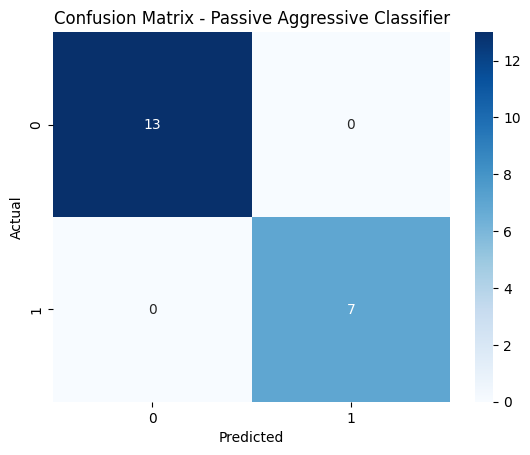

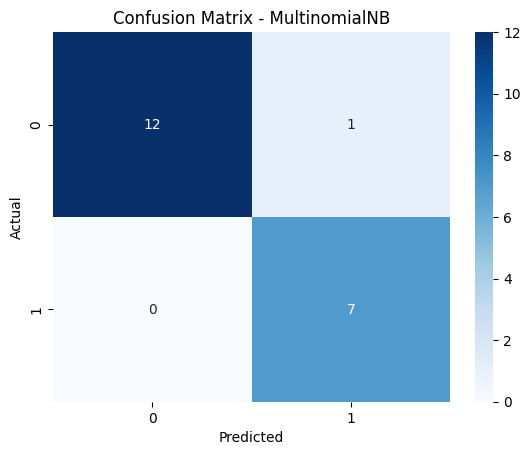

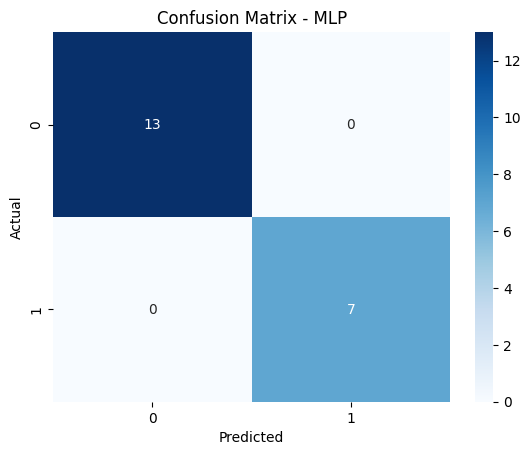

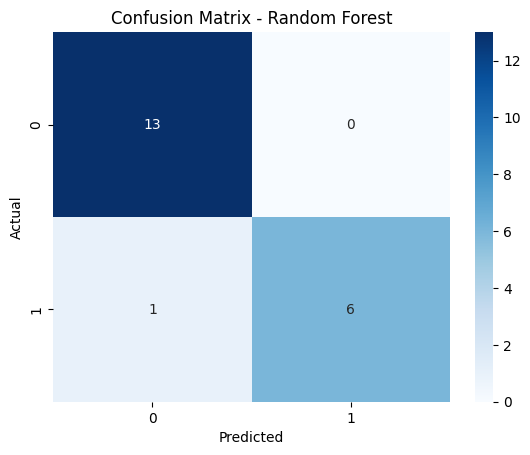

In [38]:
# Confusion Matrix - Passive Aggressive Classifier
cm = confusion_matrix(test_labels, prediction)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.show()

# Confusion Matrix - MultinomialNB
cm2 = confusion_matrix(test_labels, prediction2)
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MultinomialNB')
plt.show()

# Confusion Matrix - MLP
cm3 = confusion_matrix(test_labels, prediction3)
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLP')
plt.show()

# Confusion Matrix - Random Forest
cm4 = confusion_matrix(test_labels, prediction4)
sns.heatmap(cm4, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()